In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import itertools
from sklearn.preprocessing import StandardScaler
import sys
from pathlib import Path

parent_dir = Path.cwd().parent.parent

if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))
from shared.metrics import print_evaluation_metrics
from shared.helpers import store_model
from shared.lstm import create_data
from shared.helpers import store_predictions_and_create_graph

In [4]:
file_path = "../data/parsed_dataset.csv"
date_column = "Date_reported"
target_column = "New_deaths"
df = pd.read_csv(file_path, parse_dates=True)
df = df[[date_column, target_column, "New_cases_30_days_ago"]]

df = df.groupby(date_column).sum().reset_index()
df.set_index(date_column, inplace=True)
df = df.dropna()
dates = df.index.values

In [5]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
scaled_data.shape

(1390, 2)

In [6]:
X_train, X_test, X_val, y_train, y_test, y_val = create_data(
    scaled_data,
    n_future=1,
    n_past=30,
    train_test_split_percentage=0.9,
    validation_split_percentage=0,
)

In [17]:
regressor = Sequential()
regressor.add(
    LSTM(
        units=16,
        return_sequences=True,
        input_shape=(X_train.shape[1], X_train.shape[2]),
    )
)
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=16, return_sequences=False))
regressor.add(Dropout(0.2))
regressor.add(Dense(units=1, activation="linear"))
regressor.compile(
    optimizer=tf.keras.optimizers.Adam(), loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

regressor.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 30, 16)            1216      
                                                                 
 dropout_4 (Dropout)         (None, 30, 16)            0         
                                                                 
 lstm_5 (LSTM)               (None, 16)                2112      
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 3345 (13.07 KB)
Trainable params: 3345 (13.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)
history = regressor.fit(
    X_train, y_train, validation_split=0.3, epochs=200, batch_size=64, callbacks=[es]
)

Epoch 1/200
14/14 [==============================] - 2s 41ms/step - loss: 0.6665 - root_mean_squared_error: 0.8164 - val_loss: 0.2891 - val_root_mean_squared_error: 0.5377
Epoch 2/200
14/14 [==============================] - 0s 12ms/step - loss: 0.4498 - root_mean_squared_error: 0.6707 - val_loss: 0.1847 - val_root_mean_squared_error: 0.4298
Epoch 3/200
14/14 [==============================] - 0s 12ms/step - loss: 0.4306 - root_mean_squared_error: 0.6562 - val_loss: 0.1527 - val_root_mean_squared_error: 0.3907
Epoch 4/200
14/14 [==============================] - 0s 12ms/step - loss: 0.3978 - root_mean_squared_error: 0.6308 - val_loss: 0.1262 - val_root_mean_squared_error: 0.3553
Epoch 5/200
14/14 [==============================] - 0s 12ms/step - loss: 0.4091 - root_mean_squared_error: 0.6396 - val_loss: 0.1312 - val_root_mean_squared_error: 0.3622
Epoch 6/200
14/14 [==============================] - 0s 11ms/step - loss: 0.4014 - root_mean_squared_error: 0.6335 - val_loss: 0.1270 - val_

In [19]:
results = regressor.evaluate(X_test, y_test)
print("test loss, test acc:", np.round(results, 4))

5/5 [==============================] - 0s 3ms/step - loss: 0.0920 - root_mean_squared_error: 0.3033
test loss, test acc: [0.092  0.3033]


In [20]:
def LSTM_HyperParameter_Tuning(config, x_train, y_train, x_test, y_test):
    (
        first_additional_layer,
        second_additional_layer,
        third_additional_layer,
        n_neurons,
        n_batch_size,
        dropout,
    ) = config
    possible_combinations = list(
        itertools.product(
            first_additional_layer,
            second_additional_layer,
            third_additional_layer,
            n_neurons,
            n_batch_size,
            dropout,
        )
    )

    print(possible_combinations)
    print("\n")

    hist = []

    for i in range(0, len(possible_combinations)):
        print(f"{i+1}th combination: \n")
        print("--------------------------------------------------------------------")

        (
            first_additional_layer,
            second_additional_layer,
            third_additional_layer,
            n_neurons,
            n_batch_size,
            dropout,
        ) = possible_combinations[i]

        regressor = Sequential()
        regressor.add(
            LSTM(
                units=n_neurons,
                return_sequences=True,
                input_shape=(x_train.shape[1], x_train.shape[2]),
            )
        )
        regressor.add(Dropout(dropout))

        if first_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if second_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if third_additional_layer:
            regressor.add(GRU(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        regressor.add(LSTM(units=n_neurons, return_sequences=False))
        regressor.add(Dropout(dropout))
        regressor.add(Dense(units=1, activation="linear"))
        regressor.compile(
            optimizer=tf.keras.optimizers.Adam(),
            loss="mse",
            metrics=[tf.keras.metrics.RootMeanSquaredError()],
        )

        es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)

        file_path = "best_model.h5"

        mc = ModelCheckpoint(
            file_path, monitor="val_loss", mode="min", verbose=1, save_best_only=True
        )


        regressor.fit(
            x_train,
            y_train,
            validation_split=0.3,
            epochs=1000,
            batch_size=n_batch_size,
            callbacks=[es, mc],
            verbose=0,
        )

        train_accuracy = regressor.evaluate(x_train, y_train, verbose=0)
        test_accuracy = regressor.evaluate(x_test, y_test, verbose=0)

        hist.append(
            list(
                (
                    first_additional_layer,
                    second_additional_layer,
                    third_additional_layer,
                    n_neurons,
                    n_batch_size,
                    dropout,
                    train_accuracy,
                    test_accuracy,
                )
            )
        )

        print(
            f"{str(i)}-th combination = {possible_combinations[i]} \n train accuracy: {train_accuracy} and test accuracy: {test_accuracy}"
        )

    return hist

In [21]:
config = [
    [True, False],
    [True, False],
    [True, False],
    [64, 128, 256],
    [7, 28,365],
    [0.2],
]

hist = LSTM_HyperParameter_Tuning(
    config, X_train, y_train, X_test, y_test
)

[(True, True, True, 64, 7, 0.2), (True, True, True, 64, 28, 0.2), (True, True, True, 64, 365, 0.2), (True, True, True, 128, 7, 0.2), (True, True, True, 128, 28, 0.2), (True, True, True, 128, 365, 0.2), (True, True, True, 256, 7, 0.2), (True, True, True, 256, 28, 0.2), (True, True, True, 256, 365, 0.2), (True, True, False, 64, 7, 0.2), (True, True, False, 64, 28, 0.2), (True, True, False, 64, 365, 0.2), (True, True, False, 128, 7, 0.2), (True, True, False, 128, 28, 0.2), (True, True, False, 128, 365, 0.2), (True, True, False, 256, 7, 0.2), (True, True, False, 256, 28, 0.2), (True, True, False, 256, 365, 0.2), (True, False, True, 64, 7, 0.2), (True, False, True, 64, 28, 0.2), (True, False, True, 64, 365, 0.2), (True, False, True, 128, 7, 0.2), (True, False, True, 128, 28, 0.2), (True, False, True, 128, 365, 0.2), (True, False, True, 256, 7, 0.2), (True, False, True, 256, 28, 0.2), (True, False, True, 256, 365, 0.2), (True, False, False, 64, 7, 0.2), (True, False, False, 64, 28, 0.2), (Tr

/home/samuell/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 0.20662 to 0.10123, saving model to best_model.h5

Epoch 3: val_loss did not improve from 0.10123

Epoch 4: val_loss did not improve from 0.10123

Epoch 5: val_loss did not improve from 0.10123

Epoch 6: val_loss did not improve from 0.10123

Epoch 7: val_loss did not improve from 0.10123
Epoch 7: early stopping
0-th combination = (True, True, True, 64, 7, 0.2) 
 train accuracy: [0.2726670503616333, 0.5221753120422363] and test accuracy: [0.05774252861738205, 0.24029675126075745]
2th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 0.10484, saving model to best_model.h5

Epoch 2: val_loss did not improve from 0.10484

Epoch 3: val_loss improved from 0.10484 to 0.09598, saving model to best_model.h5

Epoch 4: val_loss did not improve from 0.09598

Epoch 5: val_loss did not improve from 0.09598

Epoch 6: val_loss did not improve from 0.09598

Epoch 7: val_loss did not improve from 

In [22]:
hist = pd.DataFrame(hist)
hist = hist.sort_values(by=[7], ascending=True)
hist

,0,1,2,3,4,5,6,7
36,False,True,True,64,7,0.2,"[0.1942443698644638, 0.44073164463043213]","[0.0042057218961417675, 0.0648515373468399]"
61,False,False,True,256,28,0.2,"[0.21367475390434265, 0.46224966645240784]","[0.0048001972027122974, 0.06928345561027527]"
33,True,False,False,256,7,0.2,"[0.11451060324907303, 0.3383941650390625]","[0.004805008415132761, 0.06931816786527634]"
25,True,False,True,256,28,0.2,"[0.25741901993751526, 0.507364809513092]","[0.004898503888398409, 0.06998931616544724]"
49,False,True,False,128,28,0.2,"[0.2597772479057312, 0.5096834897994995]","[0.0049067004583776, 0.07004784047603607]"
...,...,...,...,...,...,...,...,...
60,False,False,True,256,7,0.2,"[0.2503170669078827, 0.5003169775009155]","[0.1532352715730667, 0.39145275950431824]"
19,True,False,True,64,28,0.2,"[0.2974695861339569, 0.5454077124595642]","[0.1645006388425827, 0.40558677911758423]"
2,True,True,True,64,365,0.2,"[0.3106691837310791, 0.5573770403862]","[0.18070292472839355, 0.4250916540622711]"
6,True,True,True,256,7,0.2,"[0.23740564286708832, 0.4872429072856903]","[0.2091623693704605, 0.4573427140712738]"


In [23]:
print(
    f"Best Combination: \n first_additional_layer = {hist.iloc[0, 0]}\n second_additional_layer = {hist.iloc[0, 1]}\n third_additional_layer = {hist.iloc[0, 2]}\n n_neurons = {hist.iloc[0, 3]}\n n_batch_size = {hist.iloc[0, 4]}\n dropout = {hist.iloc[0, 5]}"
)
print("**************************")
print(f"Results Before Tunning:\n Test Set RMSE: {np.round(results, 4)[1]}\n")
print(f"Results After Tunning:\n Test Set RMSE: {np.round(hist.iloc[0, -1], 4)[1]}\n")
print(
    f"{np.round((results[1] - hist.iloc[0, -1][1])*100/np.round(results, 4)[1])}% Improvement"
)

Best Combination: 
 first_additional_layer = False
 second_additional_layer = True
 third_additional_layer = True
 n_neurons = 64
 n_batch_size = 7
 dropout = 0.2
**************************
Results Before Tunning:
 Test Set RMSE: 0.3033

Results After Tunning:
 Test Set RMSE: 0.0649

79.0% Improvement


In [24]:
list(hist.iloc[0, :-2])

[False, True, True, 64, 7, 0.2]

In [25]:
(
    first_additional_layer,
    second_additional_layer,
    third_additional_layer,
    n_neurons,
    n_batch_size,
    dropout,
) = list(hist.iloc[0, :-2])

In [26]:
regressor = Sequential()
regressor.add(
    LSTM(
        units=n_neurons,
        return_sequences=True,
        input_shape=(X_train.shape[1], X_train.shape[2]),
    )
)
regressor.add(Dropout(dropout))

if first_additional_layer:
    regressor.add(LSTM(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

if second_additional_layer:
    regressor.add(LSTM(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

if third_additional_layer:
    regressor.add(GRU(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

regressor.add(LSTM(units=n_neurons, return_sequences=False))
regressor.add(Dropout(dropout))
regressor.add(Dense(units=1, activation="linear"))
regressor.compile(optimizer=tf.keras.optimizers.Adam(), loss="mse")

es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)

file_path = "best_model.h5"

mc = ModelCheckpoint(
    file_path, monitor="val_loss", mode="min", verbose=1, save_best_only=True
)

regressor.fit(
    X_train,
    y_train,
    validation_split=0.3,
    epochs=200,
    batch_size=n_batch_size,
    callbacks=[es, mc],
    verbose=0,
)


Epoch 1: val_loss improved from inf to 0.09056, saving model to best_model.h5


/home/samuell/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 0.09056 to 0.08870, saving model to best_model.h5

Epoch 3: val_loss did not improve from 0.08870

Epoch 4: val_loss did not improve from 0.08870

Epoch 5: val_loss did not improve from 0.08870

Epoch 6: val_loss did not improve from 0.08870

Epoch 7: val_loss did not improve from 0.08870
Epoch 7: early stopping


In [27]:
regressor.evaluate(X_test, y_test)

5/5 [==============================] - 0s 8ms/step - loss: 0.1805


0.18046359717845917

In [8]:
y_pred = regressor.predict(X_test)

5/5 [==============================] - 1s 7ms/step


In [9]:
non_zero = []
scaler = StandardScaler()
scaler.fit(df[[target_column]])
unscaled_y_pred = scaler.inverse_transform([y_pred.flatten()])[0]
unscaled_y_test = scaler.inverse_transform([y_test.flatten()])[0]
unscaled_y_train = scaler.inverse_transform([y_train.flatten()])[0]
for i in unscaled_y_pred:
    removed_initial_one = i-1
    if removed_initial_one == 0:
        non_zero.append(removed_initial_one+sys.float_info.min)
    else:
        non_zero.append(removed_initial_one)

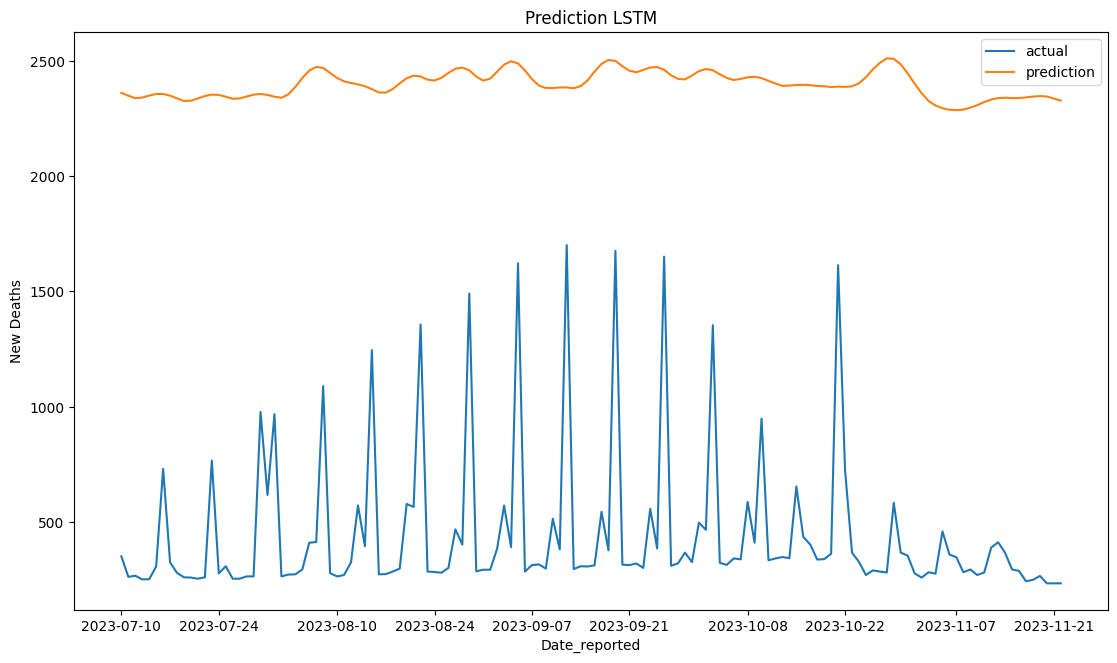

In [10]:


import matplotlib.dates as mdates
data_length = len(unscaled_y_test)

fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(dates[-data_length:], unscaled_y_test-1, label="actual")
ax.plot(dates[-data_length:], non_zero, label="prediction")
ax.set_title("Prediction LSTM")
ax.set_ylabel("New Deaths")
ax.set_xlabel(date_column)
ax.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.show()

In [11]:
print_evaluation_metrics(unscaled_y_pred, unscaled_y_test-1, unscaled_y_train-1)

Evaluation Metrics:
MSE: 3909130.11
RMSE: 1977.15
MAE: 1951.63
MAPE: 580.66
SMAPE: 140.75
MASE: 1.11


In [12]:
store_model(regressor, "lstm")

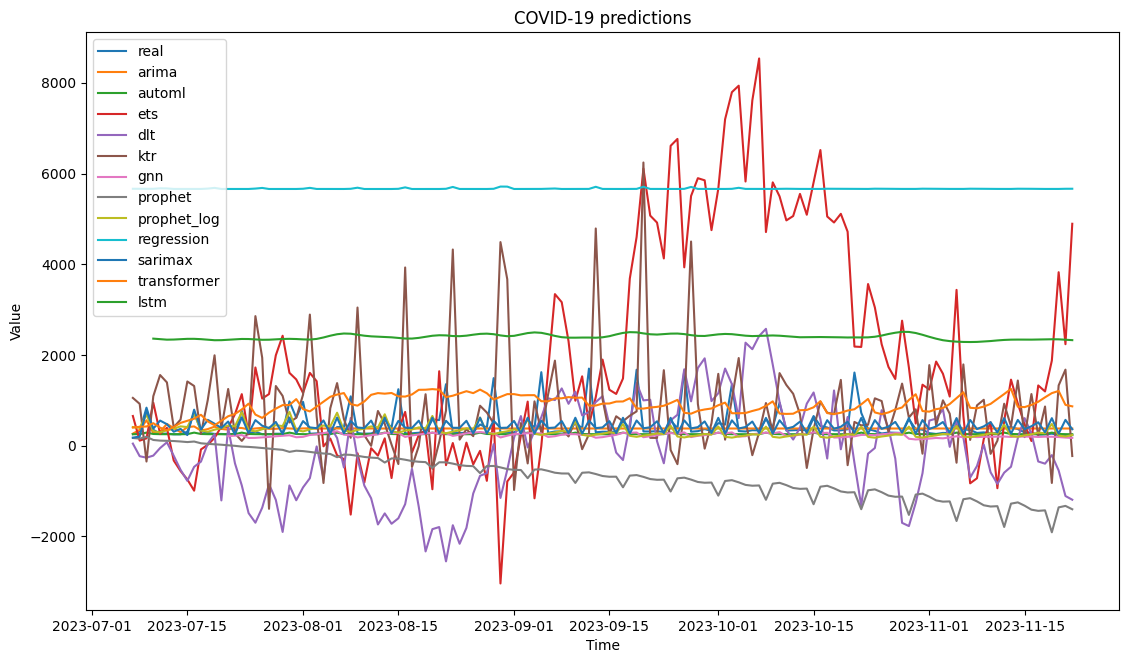

In [13]:
store_predictions_and_create_graph("lstm", dates[-data_length:], unscaled_y_pred, unscaled_y_test-1, "COVID-19")